<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/GDF_OPS_applications/blob/main/airbnb.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# POST ON AIRBNB!


I  have a place I wish to rent on AirBnb:


In [2]:
myEstate="199 Marlborough St, Boston, MA 02116"

It is an **entire unit** with **one bedrooms**.

## The Problem



> How much may I charge for my unit?

## The rationale

> I will find a fair price based on what others owners are charging nearby.

## Getting ready

### Installations

We will need some help from two new libraries:

- **PYSAL** will offer functions to interpolate, that is, estimate an unknown value in a location, based on known values in other locations in the greater area of reference.

- **H3**, which will divide the greater area of reference into smaller pieces. H3 will create a grid of hexagons. [H3 is an Uber idea](https://www.uber.com/en-PE/blog/h3/).

In [1]:
!pip install pysal h3

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━

### The Data

We will work on Boston data.

Besides the Boston [boundaries map](https://www.mass.gov/info-details/massgis-data-municipalities), we will know the prices of other locations using [insideairbnb](https://insideairbnb.com/get-the-data/).

Let's get the data:




In [3]:
import pandas as pd
import geopandas as gpd


linkBostonBorder="https://github.com/690D-Spacial-Data-Analysis/Homwork2/raw/refs/heads/main/GISDATA.TOWNSSURVEY_POLYM.zip"
boston=gpd.read_file(linkBostonBorder)

linkBostonAIrbnb="https://github.com/690D-Spacial-Data-Analysis/Homwork2/raw/refs/heads/main/listings.csv"
airbnb_all=pd.read_csv(linkBostonAIrbnb)

The **boston** GDF is already projected, and has just one row.


In [4]:
boston

,town,town_id,type,county,fips_stco,fourcolor,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020,popch10_20,area_acres,area_sqmi,geometry
0,BOSTON,35,C,SUFFOLK,25025,1,697197,641071,562994,574283,588957,617594,675647,58053,32104.34973,50.15997,"MULTIPOLYGON (((235056.153 904531.255, 235060...."


On the other hand, **airbnb_all** is a DF with several columns:

In [5]:
airbnb_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4560 non-null   int64  
 1   listing_url                                   4560 non-null   object 
 2   scrape_id                                     4560 non-null   int64  
 3   last_scraped                                  4560 non-null   object 
 4   source                                        4560 non-null   object 
 5   name                                          4560 non-null   object 
 6   description                                   4515 non-null   object 
 7   neighborhood_overview                         2324 non-null   object 
 8   picture_url                                   4560 non-null   object 
 9   host_id                                       4560 non-null   i

Let's keep some relevant columns:

In [6]:
keep=['id','price','bedrooms','property_type','latitude','longitude']
airbnb=airbnb_all[keep].copy()
airbnb.head()

,id,price,bedrooms,property_type,latitude,longitude
0,3781,$125.00,1.0,Entire rental unit,42.36413,-71.02991
1,5506,$142.00,1.0,Entire guest suite,42.32844,-71.09581
2,6695,$171.00,0.0,Entire condo,42.32802,-71.09387
3,8789,$140.00,1.0,Entire rental unit,42.35867,-71.06307
4,10811,$152.00,0.0,Entire rental unit,42.35173,-71.08685


Re check the data types:

In [7]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4560 non-null   int64  
 1   price          3695 non-null   object 
 2   bedrooms       4291 non-null   float64
 3   property_type  4560 non-null   object 
 4   latitude       4560 non-null   float64
 5   longitude      4560 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 213.9+ KB


We need to clean and format the **price** column:

In [8]:
airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)

,price
0,125.0
1,142.0
2,171.0
3,140.0
4,152.0
...,...
4555,332.0
4556,200.0
4557,102.0
4558,299.0


Let's make the change, and get rid of missing data:

In [9]:
#then

airbnb['price']=airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)
# bye missing data
airbnb.dropna(inplace=True)

# check
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, 0 to 4559
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3695 non-null   int64  
 1   price          3695 non-null   float64
 2   bedrooms       3695 non-null   float64
 3   property_type  3695 non-null   object 
 4   latitude       3695 non-null   float64
 5   longitude      3695 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 202.1+ KB


Using bedrooms and property type, I will keep the ones similar to mine:

In [10]:
pd.crosstab(airbnb.property_type,airbnb.bedrooms)


bedrooms,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,13.0,15.0
property_type,,,,,,,,,,,,,
Boat,0,5,2,1,0,0,0,0,0,0,0,0,0
Entire condo,25,72,74,42,11,3,1,1,0,0,0,0,1
Entire cottage,0,0,0,0,1,0,0,0,0,0,0,0,0
Entire guest suite,9,42,7,2,0,1,0,0,0,0,0,0,0
Entire guesthouse,1,2,1,0,0,0,0,0,0,0,0,0,0
Entire home,5,17,34,47,42,25,5,2,1,0,1,1,0
Entire loft,5,8,3,0,0,0,0,0,0,0,0,0,0
Entire place,1,1,0,0,0,0,0,0,1,0,0,0,0
Entire rental unit,402,729,526,195,79,10,2,0,0,0,0,0,0


Let's proceed:

In [11]:
conditionText="bedrooms==1 & property_type=='Entire rental unit'"
airbnb_source=airbnb.query(conditionText).copy()
airbnb_source

,id,price,bedrooms,property_type,latitude,longitude
0,3781,125.0,1.0,Entire rental unit,42.364130,-71.029910
3,8789,140.0,1.0,Entire rental unit,42.358670,-71.063070
8,29765,272.0,1.0,Entire rental unit,42.377540,-71.066420
10,45987,100.0,1.0,Entire rental unit,42.374240,-71.060810
13,60356,100.0,1.0,Entire rental unit,42.358940,-71.063100
...,...,...,...,...,...,...
4522,1434832305310188416,275.0,1.0,Entire rental unit,42.350506,-71.081736
4524,1434881337152781656,161.0,1.0,Entire rental unit,42.341253,-71.078610
4530,1436235178529920120,408.0,1.0,Entire rental unit,42.347210,-71.038000
4544,1439950737462089453,145.0,1.0,Entire rental unit,42.342526,-71.080776


Time to turn the DF of airbnb into a GDF:

- No duplicated units:

In [12]:
# Create a list of columns that must be identical to be considered a duplicate
key_columns = ['latitude', 'longitude']

# Remove rows that are identical across the key columns
airbnb_source_unique = airbnb_source.drop_duplicates(subset=key_columns)

- Into GDF:

In [13]:
airbnb_source_gdf = gpd.GeoDataFrame(
    airbnb_source_unique,
    geometry=gpd.points_from_xy(airbnb_source_unique.longitude,
                                airbnb_source_unique.latitude),
    crs='EPSG:4326') #long / lat



airbnb_source_gdf=airbnb_source_gdf.to_crs(boston.crs)

Let's see both layers:

<Axes: >

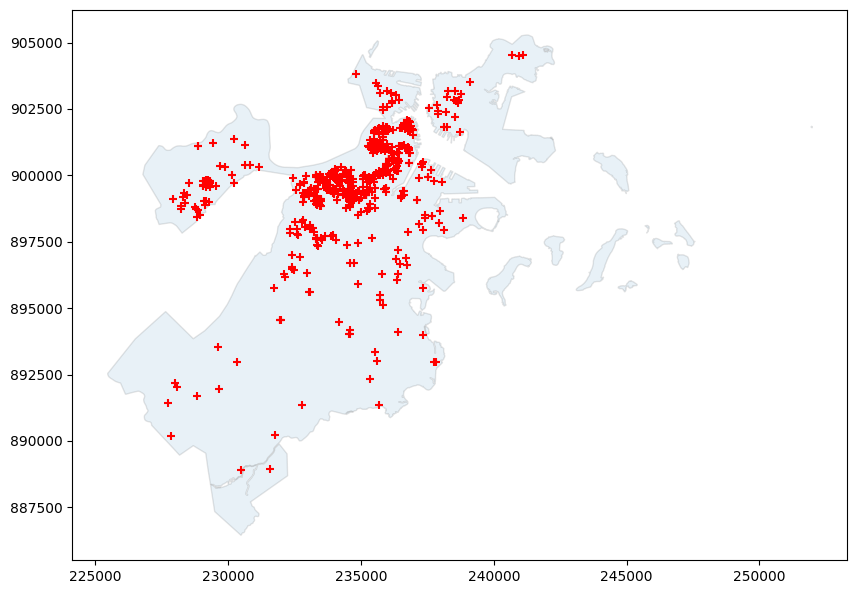

In [14]:
base=boston.plot(figsize=(10,10),alpha=0.1,edgecolor='black')
airbnb_source_gdf.plot(ax=base,marker="+",color='red')

## The need for Spatial Interpolation


We have a unit for rent, but there is no catalog that tells us how much one should charge. We could ask friends and familiy  for suggestions, but we decide to estimate the rental charge based on what others charge. Then, with lots of prices around, we need to see how proximity plays a role to propose a fair price for our estate. That is when interpolation comes to our help.

Spatial Interpolation assumes Waldo Tobler's [idea](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography) that proximity influences spatially located phenonenom. So, spatial interpolation is the mathematical process that formalizes this idea. It takes our scattered known prices and creates a continuous surface of predicted prices that covers our entire neighborhood, thus allowing us to estimate the price for our specific unlisted location.

Spatial Interpolation has two flavors:
- Areal Interpolation
- Point Interpolation

Our case is **Point Interpolation**, an interpolation of values (prices) from a sparse set of points (the AirBnb units known similar to mine) to any other location in between (we will prepare this soon).

### Creating Target Grid

We have known data:

- Current AirBnb unit locations similar to mine.
- The reantal prices of those AirBnb units.
- The address of my unit.

We do not have:
- The rental price of my unit.

We need a GRID of points, where each point ideally represents potential rental locations with its own rental prices. Since not every point on the grid has a rental price, that value will be estimated from the locations with known rental prices.

How to get that grid?

- **option 1**. Let's get a satellite image of the area that covers Boston, the image should have a sufficient high resolution to identify at least house level area. Several operation would be needed (defining pixel size, extent/clipping, and aligning coordinates), and get the centroid of the square retrieved.

- **option 2**. Let's use UBER's H3 grid. This will split Boston into lots of hexagons with a proper resolution, and get the centroids of those hexagons.

The easiest choice, and likely better, would be the **option 2**. These are the steps:

- call "tobler" library
- use "tobler.util.h3fy" function on "boston" GDF with a "resolution" of 10.
- You would get a warning. But to avoid it:
  * In _tobler.util.h3fy_ use _boston_ with the crs 4326
  * Reproject the result of _tobler.util.h3fy_ with the original _boston_ crs.




In [15]:
import tobler

# this gives a warning, no worries
tobler.util.h3fy(boston, resolution=10)

/usr/local/lib/python3.12/dist-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


,geometry
hex_id,
8a2a3064ba0ffff,"POLYGON ((231600.591 889236.958, 231522.513 88..."
8a2a3064bb57fff,"POLYGON ((231810.399 889408.683, 231732.32 889..."
8a2a33916417fff,"POLYGON ((230883.547 887911.688, 230805.474 88..."
8a2a3064948ffff,"POLYGON ((232022.612 889779.296, 231971.359 88..."
8a2a339a5d5ffff,"POLYGON ((229460.922 888371.756, 229382.846 88..."
...,...
8a2a302955affff,"POLYGON ((243870.22 900609.349, 243897.102 900..."
8a2a30295547fff,"POLYGON ((244258.273 900483.686, 244180.157 90..."
8a2a302953b7fff,"POLYGON ((244768.055 899718.902, 244689.943 89..."


In [16]:
# this gives no warning, but NOT really needed:
boston_grid10=tobler.util.h3fy(boston.to_crs(4326), resolution=10).to_crs(boston.crs)

Notice we used a prastical level of **resolution** for our case, you can use higher or lower [values](https://gist.github.com/colbyn/001064f00385d253b42693c3889f9beb) depending on the project.

Now, we get the points from the hexagons:

In [17]:
boston_target_locations = boston_grid10.centroid.get_coordinates()
boston_target_locations.head()

,x,y
hex_id,,
8a2a3064ba0ffff,231573.765522,889165.774055
8a2a3064bb57fff,231783.572565,889337.498072
8a2a33916417fff,230856.726436,887840.513226
8a2a3064948ffff,231944.532028,889764.618296
8a2a339a5d5ffff,229434.104702,888300.576884


We do not estimate prices for the hexagons, we estimate prices for their centroids, now **boston_target_locations**.

### The Estimation approaches


Let's organize the input for  the estimations:

- These are coordinates of the airbnb units:

In [18]:
airbnb_source_locations = airbnb_source_gdf.get_coordinates()
airbnb_source_locations

,x,y
0,238723.071602,901621.028543
3,235994.689856,901000.033972
8,235708.061666,903094.621091
10,236171.964058,902730.435041
13,235992.064834,901030.011639
...,...,...
4522,234461.455887,900085.556391
4524,234724.057239,899059.008634
4530,238066.854301,899737.997844
4544,234544.881680,899199.519500


- These are the known rental prices

In [19]:
airbnb_source_gdf.price

,price
0,125.0
3,140.0
8,272.0
10,100.0
13,100.0
...,...
4522,275.0
4524,161.0
4530,408.0
4544,145.0


- This is the target grid:

In [20]:
boston_target_locations

,x,y
hex_id,,
8a2a3064ba0ffff,231573.765522,889165.774055
8a2a3064bb57fff,231783.572565,889337.498072
8a2a33916417fff,230856.726436,887840.513226
8a2a3064948ffff,231944.532028,889764.618296
8a2a339a5d5ffff,229434.104702,888300.576884
...,...,...
8a2a302955affff,243818.984344,900665.923809
8a2a30295547fff,244231.390812,900412.427896
8a2a302953b7fff,244741.172328,899647.649689


Notice none of the data above are geo data, but the projected locations (x,y) can used in other programs. Let's make several estimations:

- **approach 1**: I will charge the same as the closest airbnb similar to mine.

<Axes: >

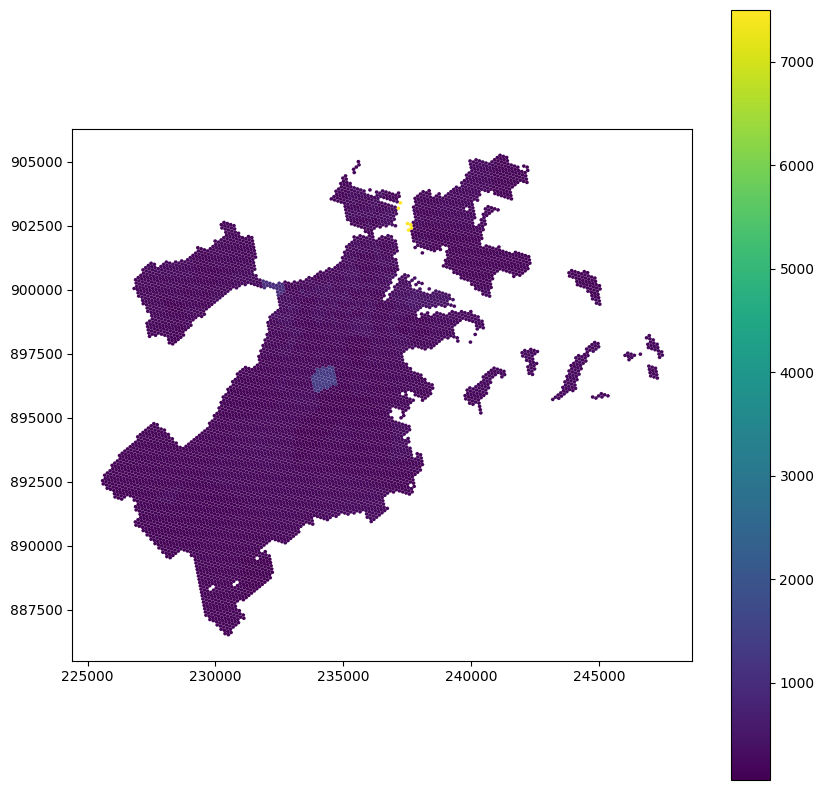

In [21]:
from scipy.interpolate import griddata

boston_grid10["nearest"] = griddata(points=airbnb_source_locations,
                                    values=airbnb_source_gdf.price,
                                    xi=boston_target_locations,
                                    method="nearest")

# here we have:

boston_grid10.plot('nearest', legend=True,figsize=(10,10))

- **approach 2**: I will charge the same as the average of the closest similar AirBnb rental units. How many 'closest units', that **K** value may vary. I will use 10.

<Axes: >

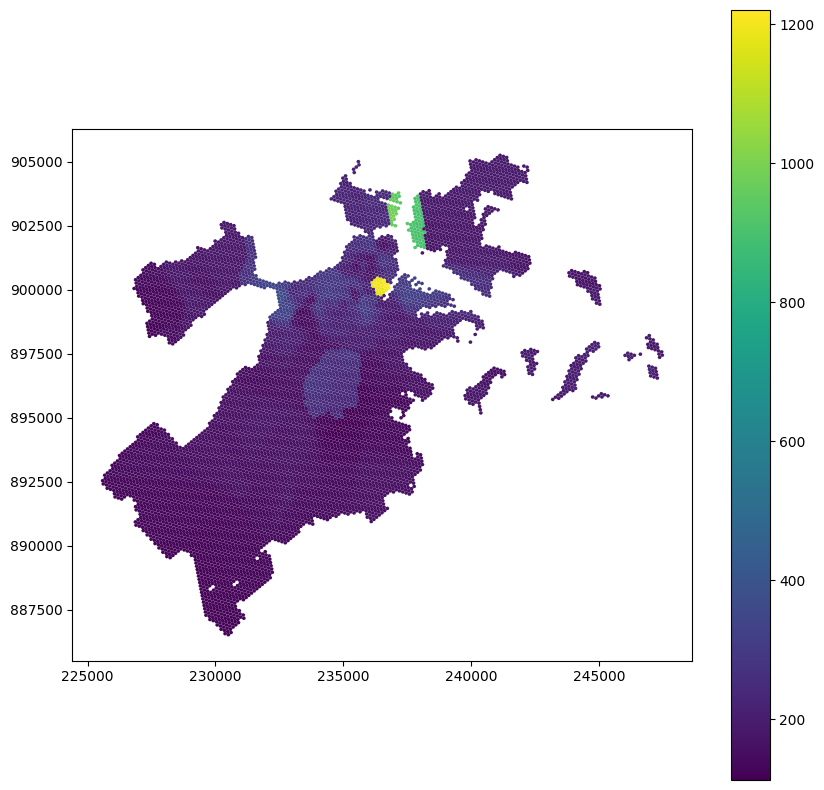

In [22]:
from sklearn.neighbors import KNeighborsRegressor

interpolation_uniform = KNeighborsRegressor(n_neighbors=10,
                                            weights="uniform").\
                                            fit(airbnb_source_locations,
                                                airbnb_source_gdf.price)

boston_grid10["knn10_uniform"] = interpolation_uniform.predict(boston_target_locations)

# here we have
boston_grid10.plot("knn10_uniform", legend=True,figsize=(10,10))

- **approach 3**: I will charge based on some close AirBnb rental units, I will weight the average based on their distance to me, a closer unit will weight more, a farther unit will weight less. This is alsa called IDW (Inverse Distance Weight).

<Axes: >

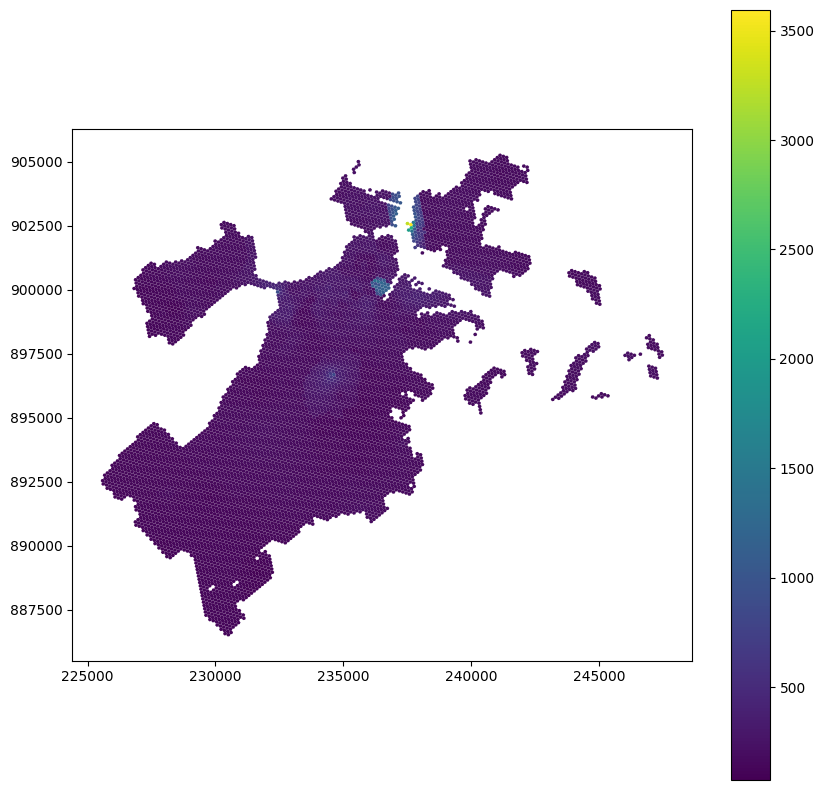

In [23]:



interpolation_IDW = KNeighborsRegressor(n_neighbors=10,
                                            weights="distance").\
                                            fit(airbnb_source_locations,
                                                airbnb_source_gdf.price)

boston_grid10["IDW_10"] = interpolation_IDW.predict(boston_target_locations)

# here we have
boston_grid10.plot("IDW_10", legend=True,figsize=(10,10))

- **approach 4**: I will charge based on all AirBnb rental units located within a fixed radius of 1000 meters from my unit. I will then weight the average based on their distance to me, so a closer unit will weight more, and a farther unit will weight less. This is essentially Inverse Distance Weighting (IDW) where the size of the local neighborhood is defined by a distance (1000m) instead of a fixed number of neighbors.

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


<Axes: >

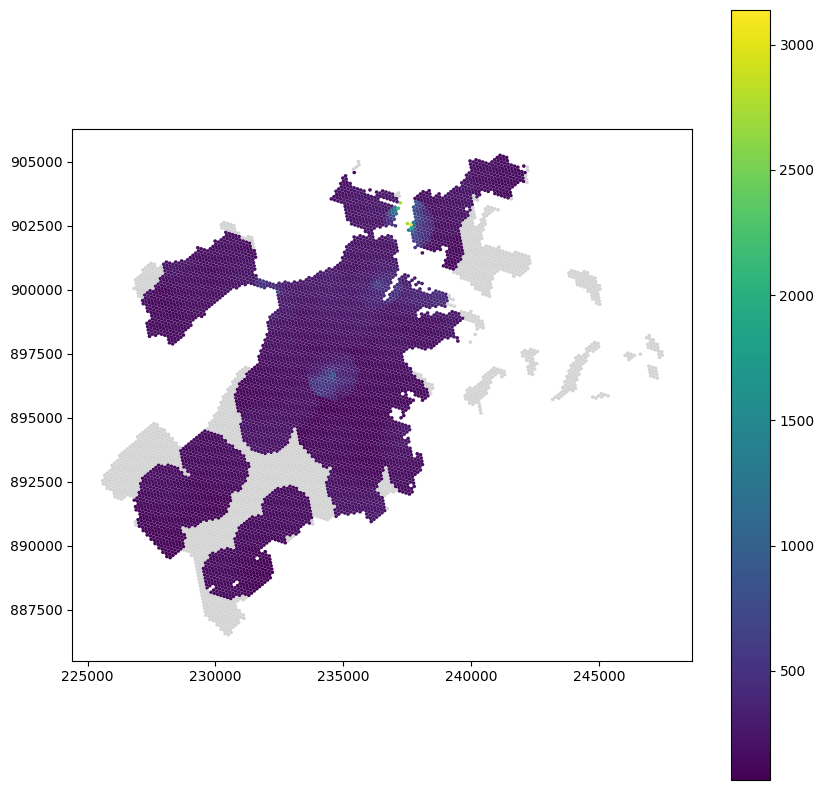

In [24]:
from sklearn.neighbors import RadiusNeighborsRegressor

interpolation_radius = RadiusNeighborsRegressor(
    radius=1000, weights="distance"
)
interpolation_radius.fit(
    airbnb_source_locations, airbnb_source_gdf.price
)

boston_grid10["radius_1000"] = interpolation_radius.predict(boston_target_locations)

boston_grid10.plot("radius_1000", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))

## So, How much should I charge

Some previous steps:


1.   Find the coordinates of my unit: This is good time to *geocode*.



In [25]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point

geolocator = Nominatim(user_agent="theGeocoder")

myEstate_Address = geolocator.geocode(myEstate)

# see
myEstate_Address

Location(199, Marlborough Street, Back Bay, Boston, Suffolk County, Massachusetts, 02116, United States of America, (42.3525254, -71.080804, 0.0))

The **geolocator.geocode** returned a **Location** structure. You can access each piece of information from this structure like this:

In [26]:
myEstate_Address.address, myEstate_Address.longitude,myEstate_Address.latitude

('199, Marlborough Street, Back Bay, Boston, Suffolk County, Massachusetts, 02116, United States of America',
 -71.080804,
 42.3525254)

You can create a GDF with that:

In [27]:
myEstats_gdf4326 = gpd.GeoDataFrame(
    {'address': [myEstate_Address.address]},
    geometry=[Point(myEstate_Address.longitude, myEstate_Address.latitude)],
    crs="EPSG:4326" # because of lon/lat
)

# reprojecting
myEstats_gdf = myEstats_gdf4326.to_crs(boston.crs)

# here it is
myEstats_gdf


,address,geometry
0,"199, Marlborough Street, Back Bay, Boston, Suf...",POINT (234537.113 900310.189)


2. Find in which hexagon my unit is located, and bring those prices:

In [28]:
myEstats_gdf.sjoin(
    boston_grid10,
    how="left",
    predicate="within"
)

,address,geometry,hex_id,nearest,knn10_uniform,IDW_10,radius_1000
0,"199, Marlborough Street, Back Bay, Boston, Suf...",POINT (234537.113 900310.189),8a2a306631affff,187.0,289.9,289.514314,277.786358


You decide:

| Price Interpolation Method | Price Recommendation | Rationale |
|---------------------------|----------------------|-----------|
| **nearest** | The most conservative starting price. | It's based only on the price of the single closest competitor. |
| **knn10_uniform** | A balanced average price. | It smooths out the highest/lowest outliers by averaging the prices of the k nearest neighbors equally. |
| **IDW_10** | The most data-driven price (Recommended). | This is your Inverse Distance Weighting (IDW) result. It's the most robust prediction as it gives greater influence to very nearby, similar properties. |
| **radius_1000** | A highly localized price (Use with caution). | Only reflects the market of properties within a short, fixed distance. If you have a NaN here, it suggests your property is too remote for a localized comparison. |



Since we want the most data-driven price we go with the IDW_10

<Axes: >

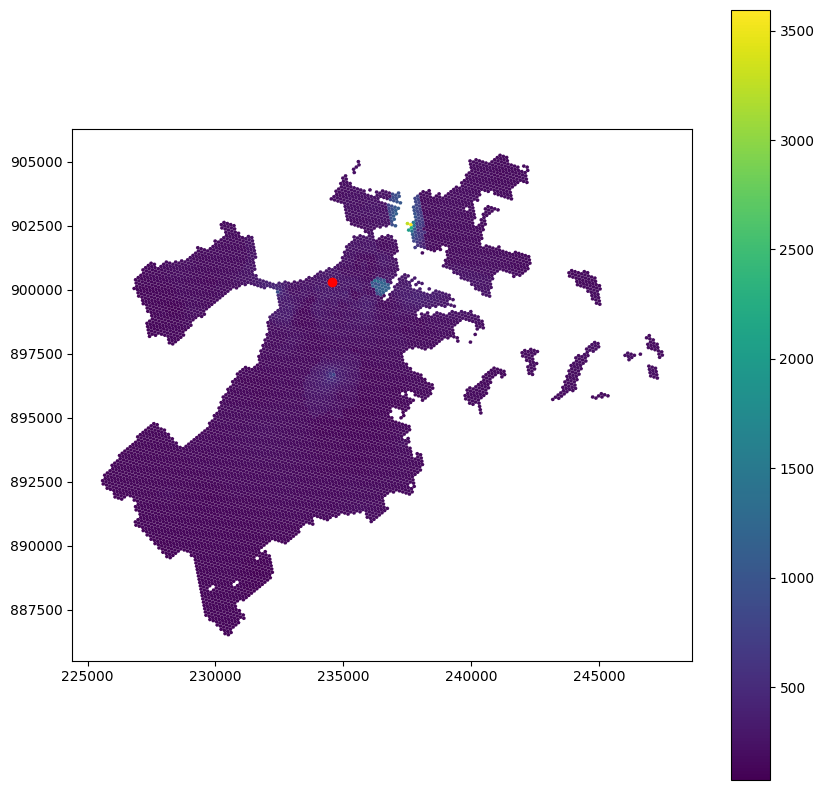

In [29]:
base=boston_grid10.plot("IDW_10", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
myEstats_gdf.plot(ax=base,color='red')

______

[BACK TO MAIN MENU](https://dacss-spatial.github.io/GDF_OPS_applications/)